References

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/05_torch_connector.html

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [58]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [67]:
#Training Dataset
# Set train shuffle seed (for reproducibility)
manual_seed(42)
classes = 5
batch_size = 32
training_samples = 500
test_samples = 250

# Use pre-defined torchvision function to load MNIST train data
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

subset = []
for i in range(classes):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)
    
full_training_data.data = full_training_data.data[subset]
full_training_data.targets = full_training_data.targets[subset]

#Split training dataset into training and validation (80%-20%)
train_size = int(0.8 * len(full_training_data))
valid_size = len(full_training_data) - train_size

train, valid = random_split(full_training_data, [train_size, valid_size])

test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

subset = []
for i in range(classes):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
print("Valid subset size:", len(valid))
print("Test subset size:", len(test))

def count(dataset):
    counter = {}
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
        
print("Training Dataset")
count(train)

print("Validation Dataset")
count(valid)

print("Testing Dataset")
count(test)

# Define torch dataloader with filtered data
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

Train subset size: 2000
Valid subset size: 500
Test subset size: 1250
Training Dataset
0 : 413
1 : 412
2 : 387
3 : 405
4 : 383
Validation Dataset
0 : 87
1 : 88
2 : 113
3 : 95
4 : 117
Testing Dataset
0 : 250
1 : 250
2 : 250
3 : 250
4 : 250


The training dataset has 2000 images
After the shuffle the 0th image has class index 3
Image shape is (28, 28, 1)


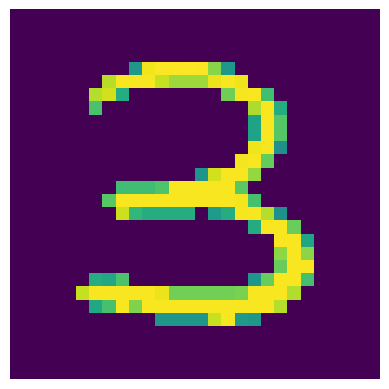

3
After the shuffle the 0th image has class index 2
Image shape is (28, 28, 1)


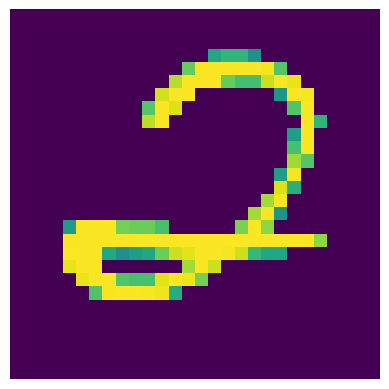

2


In [68]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)
    # im_np[im_np > 0.5] = 1
    im_np[im_np < 0.5] = 0

    # Display the image
    plt.imshow(im_np[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(class_idx)

The validation dataset has 500 images
After the shuffle the 0th image has class index 4
Image shape is (28, 28, 1)


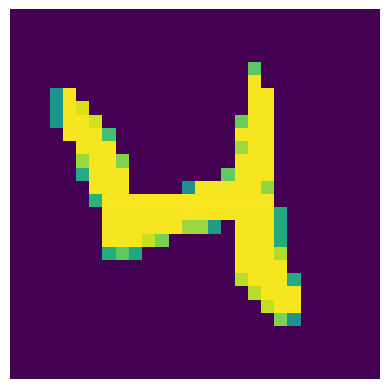

4
After the shuffle the 0th image has class index 4
Image shape is (28, 28, 1)


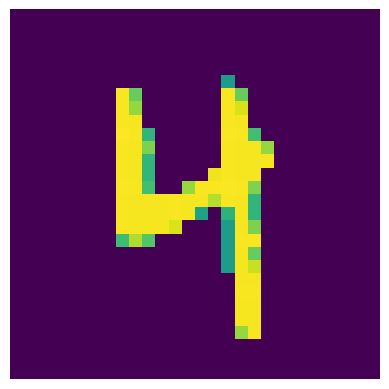

4


In [69]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid)
print(f'The validation dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = valid[indices[0]]
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)
    # im_np[im_np > 0.5] = 1
    im_np[im_np < 0.5] = 0

    # Display the image
    plt.imshow(im_np[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(class_idx)

The testing dataset has 1250 images
After the shuffle the 0th image has class index 3
Image shape is (28, 28, 1)


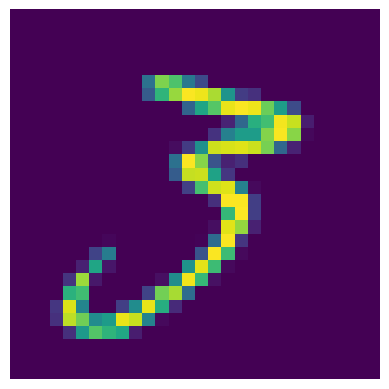

3
After the shuffle the 0th image has class index 0
Image shape is (28, 28, 1)


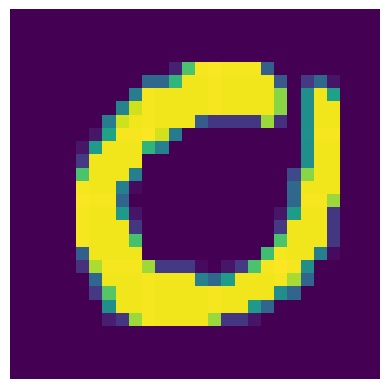

0


In [70]:
# Find and output the number of images
n = len(test)
print(f'The testing dataset has {n} images')

for i in range(2):
# Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = test[indices[0]]
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(f'Image shape is {im_np.shape}')

    # Before displaying the image rescale the intensities to be between 0 and 1
    im_min = im_np.min()
    im_max = im_np.max()
    im_np = (im_np - im_min) / (im_max - im_min)

    # Display the image
    plt.imshow(im_np)
    plt.axis('off')
    plt.show()
    print(class_idx)

In [71]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64
Using cuda device


In [72]:
'''
Neural Networks
'''

# # Define and create QNN
# def create_qnn():
#     feature_map = ZZFeatureMap(2)
#     ansatz = RealAmplitudes(2, reps=1)
#     qc = QuantumCircuit(2)
#     qc.compose(feature_map, inplace=True)
#     qc.compose(ansatz, inplace=True)

#     # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
#     qnn = EstimatorQNN( 
#         circuit=qc,
#         input_params=feature_map.parameters,
#         weight_params=ansatz.parameters,
#         input_gradients=True,
#     )
#     return qnn

# Define torch NN module
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 20, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(320, 64)
        self.fc2 = Linear(64, 32)
        self.replacement1 = Linear(32, 16)
        self.replacement2 = Linear(16, 8)
        #self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc3 = Linear(8, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.replacement1(x))
        #x = self.qnn(x)  # apply QNN
        x = self.replacement2(x)
        x = self.fc3(x)
        return x

In [73]:
#qnn4 = create_qnn()
model4 = Net().to(device)

print(model4)
for p in model4.parameters():
    print(p.size())
    
print()
mb = torch.rand(batch_size, 1, 28, 28).to(device)
logits = model4.forward(mb)
print(logits.size())

Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 20, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (replacement1): Linear(in_features=32, out_features=16, bias=True)
  (replacement2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
)
torch.Size([2, 1, 5, 5])
torch.Size([2])
torch.Size([20, 2, 5, 5])
torch.Size([20])
torch.Size([64, 320])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([8, 16])
torch.Size([8])
torch.Size([5, 8])
torch.Size([5])

torch.Size([32, 5])


In [74]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    training_loss = 0.0
    total_loss = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        total_loss.append(loss.item())
    training_loss /= len(dataloader)
    return total_loss, training_loss

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    #so that we do not compute gradients, only model performance
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            test_loss += loss_fn(output, y)
    test_loss /= num_batches
    correct /= size
    return correct

def time_elapsed(start):
    delta = datetime.now() - start
    m, s = divmod(delta.seconds, 60)
    h, m = divmod(m, 60)
    return f'Time elapsed: {h}h {m}m {int(s)}s'

In [75]:
from torch import nn
from datetime import datetime

loss_fn = nn.CrossEntropyLoss()
# loss_fn = NLLLoss()
# optimizer = torch.optim.SGD(model4.parameters(), lr=1e-4)
optimizer = optim.Adam(model4.parameters(), lr=0.001)

epochs = 50
loss_list = []  # Store loss history
start = datetime.now()
# for epoch in range(epochs):
#     total_loss = []
#     for batch_idx, (data, target) in enumerate(train_dataloader):
#         optimizer.zero_grad(set_to_none=True)  # Initialize gradient
#         output = model4(data)  # Forward pass
#         loss = loss_fn(output, target)  # Calculate loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Optimize weights
#         total_loss.append(loss.item())  # Store loss
#     loss_list.append(sum(total_loss) / len(total_loss))
#     print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

best_accuracy = 0
best_model = 'classical_best_model.pth'
best_loss = 10000
for epoch in range(epochs):
    total_loss, training_loss = train(train_dataloader, model4, loss_fn, optimizer)
    validation_accuracy = validate(valid_dataloader, model4, loss_fn)
    print("Accuracy:", best_accuracy)
    if (validation_accuracy > best_accuracy and total_loss < best_loss):
        best_accuracy = validation_accuracy
        best_loss = total_loss
        #save the model 
        torch.save(model4, best_model)
        print("Epoch:", epoch)
        # print("Training Loss:", training_loss)
        #print("Accuracy:", best_accuracy)
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    print(time_elapsed(start))
    print()
print("Done!")

Accuracy: 0
Epoch: 0
Training [2%]	Loss: 1.3111
Time elapsed: 0h 0m 0s

Accuracy: 0.812
Epoch: 1
Training [4%]	Loss: 0.5056
Time elapsed: 0h 0m 0s

Accuracy: 0.894
Training [6%]	Loss: 0.3259
Time elapsed: 0h 0m 1s

Accuracy: 0.894
Epoch: 3
Training [8%]	Loss: 0.2633
Time elapsed: 0h 0m 1s

Accuracy: 0.914
Epoch: 4
Training [10%]	Loss: 0.2170
Time elapsed: 0h 0m 2s

Accuracy: 0.942
Epoch: 5
Training [12%]	Loss: 0.1949
Time elapsed: 0h 0m 2s

Accuracy: 0.948
Epoch: 6
Training [14%]	Loss: 0.1710
Time elapsed: 0h 0m 3s

Accuracy: 0.954
Training [16%]	Loss: 0.1424
Time elapsed: 0h 0m 3s

Accuracy: 0.954
Epoch: 8
Training [18%]	Loss: 0.1223
Time elapsed: 0h 0m 4s

Accuracy: 0.964
Training [20%]	Loss: 0.1190
Time elapsed: 0h 0m 4s

Accuracy: 0.964
Training [22%]	Loss: 0.1247
Time elapsed: 0h 0m 5s

Accuracy: 0.964
Epoch: 11
Training [24%]	Loss: 0.0980
Time elapsed: 0h 0m 5s

Accuracy: 0.97
Training [26%]	Loss: 0.0911
Time elapsed: 0h 0m 6s

Accuracy: 0.97
Epoch: 13
Training [28%]	Loss: 0.0927

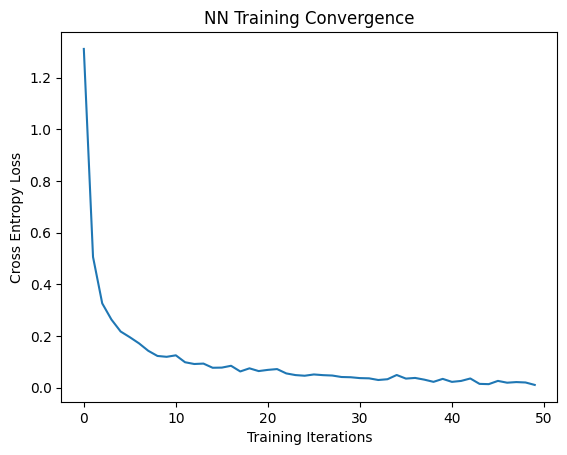

In [76]:
#Plot loss convergence
plt.plot(loss_list)
plt.title("NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [77]:
def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0.0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            output = model5(X)
            
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

            loss = loss_fn(output, y)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(dataloader) / batch_size * 100
            )
        )

# qnn5 = create_qnn()
model5 = Net().to(device)
model5 = torch.load(best_model)
test(test_dataloader, model5, loss_fn)

C:\Users\Chris\AppData\Local\Temp\ipykernel_31280\3662983638.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model5 = torch.load(best_model)


Performance on test data:
	Loss: 0.0212
	Accuracy: 97.2%


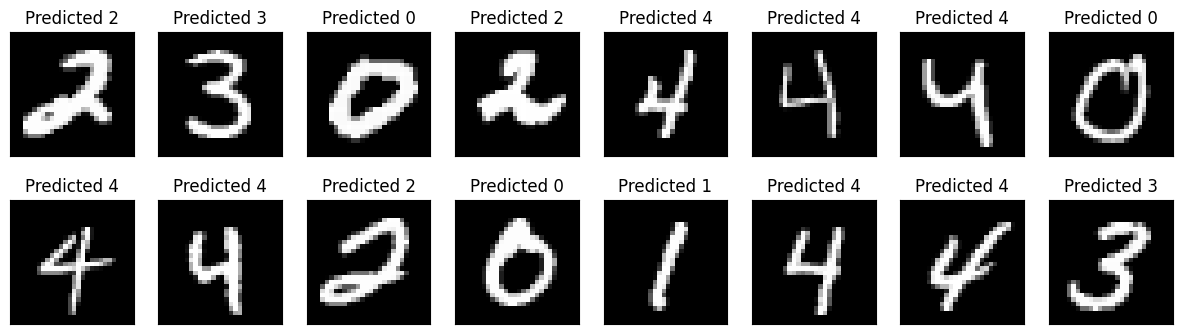

In [78]:
# Plot predicted labels
n_samples_show = 8
n_rows = 2
count = 0
fig, axes = plt.subplots(nrows=n_rows, ncols=n_samples_show, figsize=(15, 4))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        if count == n_samples_show * n_rows:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        
        row = count // n_samples_show  # Calculate row index
        col = count % n_samples_show  # Calculate column index

        axes[row, col].imshow(data[0].cpu().numpy().squeeze(), cmap="gray")

        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col].set_title("Predicted {}".format(pred.item()))

        count += 1